In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
df = pd.read_csv('TSLA.csv', index_col=0)
df.index = pd.to_datetime(df.index)

#create classes, and shift data back one (yesterdays parameters should predict today's outcome)
df['Class'] = (df['Close'] - df['Open'] > 0).mul(1).shift(-1)
df.dropna(inplace=True)

#create Lag in dataframe which will tell the nth last class
for i in range(1, 6):
    df['Lag{}'.format(i)] = df['Class'].shift(i)


df['100mav']= df['Close'].shift(1).rolling(100).mean()
df['50mav'] = df['Close'].shift(1).rolling(50).mean()
df['30mav'] = df['Close'].shift(1).rolling(30).mean()
df['10mav'] = df['Close'].shift(1).rolling(10).mean()
df['30d_high'] = df['Close'].shift(1).rolling(30).max()
df['20d_high'] = df['Close'].shift(1).rolling(20).max()
df['10d_high'] = df['Close'].shift(1).rolling(10).max()
df['5d_high'] = df['Close'].shift(1).rolling(5).max()
# df.head(20)

df.dropna(inplace=True)


In [3]:
# Dataframe with only close column
data_close = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset_close = data_close.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset_close) * .66))

In [4]:
# Scale the data
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled_data = close_scaler.fit_transform(dataset_close)
close_scaled_data

array([[0.00899965],
       [0.01022789],
       [0.01291886],
       ...,
       [0.54995031],
       [0.53629453],
       [0.56071418]])

In [5]:
# Create training data set
# Create scaled training data set
train_data = close_scaled_data[0:int(training_data_len), :]
# Split data into x-train and y-train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00899965, 0.01022789, 0.01291886, 0.01422526, 0.01523019,
       0.0150627 , 0.01395728, 0.01507386, 0.01397961, 0.01174645,
       0.01078619, 0.00946862, 0.01086435, 0.01176878, 0.01141147,
       0.01081968, 0.0097366 , 0.0074811 , 0.00867585, 0.01002691,
       0.01064103, 0.01102067, 0.01164595, 0.01205909, 0.00922297,
       0.00415369, 0.00511395, 0.00658784, 0.00521444, 0.00535959,
       0.00534843, 0.00540426, 0.00558291, 0.00675532, 0.00715729,
       0.00739178, 0.00572807, 0.00572807, 0.0049018 , 0.004377  ,
       0.00425418, 0.00245648, 0.0008821 , 0.00135107, 0.00297011,
       0.00318226, 0.00326042, 0.00345024, 0.00243415, 0.00253464,
       0.00232249, 0.00235599, 0.00200985, 0.00182003, 0.00138456,
       0.00297011, 0.00154088, 0.00155205, 0.00158555, 0.00139573])]
[0.0011277484653344112]

[array([0.00899965, 0.01022789, 0.01291886, 0.01422526, 0.01523019,
       0.0150627 , 0.01395728, 0.01507386, 0.01397961, 0.01174645,
       0.01078619, 0.00946862, 0.

In [6]:
# Build LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1495/1495 [==============================] - 27s 16ms/step - loss: 2.9574e-04


In [7]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = close_scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset_close[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = close_scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

26/26 [==============================] - 2s 17ms/step


41.194525217654856

C:\Users\Brandon\AppData\Local\Temp\ipykernel_15600\2370582738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_valid['Close Predictions'] = predictions


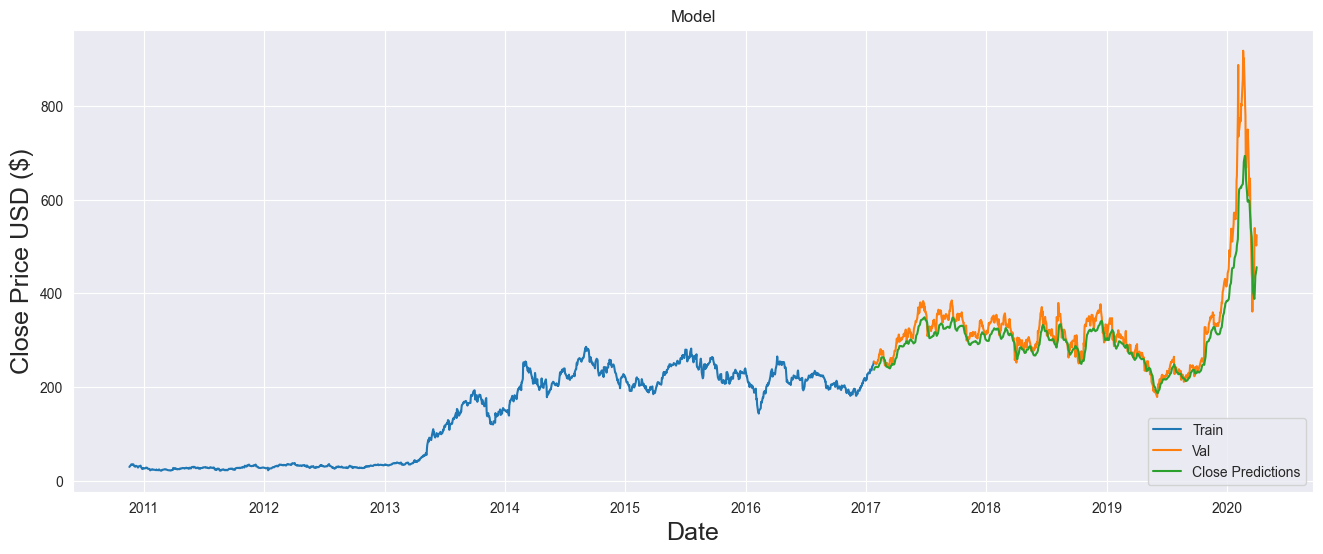

In [8]:
# Plot the data
train = data_close[:training_data_len]
close_valid = data_close[training_data_len:]
close_valid['Close Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(close_valid[['Close', 'Close Predictions']])
plt.legend(['Train', 'Val', 'Close Predictions'], loc='lower right')
plt.show()

In [9]:
close_valid

,Close,Close Predictions
Date,,
2017-01-25,254.470001,237.093872
2017-01-26,252.509995,239.831314
2017-01-27,252.949997,241.749191
2017-01-30,250.630005,243.013824
2017-01-31,251.929993,243.432922
...,...,...
2020-03-25,539.250000,398.295593
2020-03-26,528.159973,417.779541
2020-03-27,514.359985,436.567047


Now that we made a model for the closing data, let's make the same model but for open.

In [10]:
# Dataframe with only Open column
data_open = df.filter(['Open'])
# Convert the dataframe to a numpy array
dataset_open = data_open.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset_open) * .66))

In [11]:
# Scale the data
open_scaler = MinMaxScaler(feature_range=(0, 1))
open_scaled_data = open_scaler.fit_transform(dataset_open)
open_scaled_data

array([[0.00985894],
       [0.00929335],
       [0.01085703],
       ...,
       [0.53588697],
       [0.54172028],
       [0.53172825]])

In [12]:
# Create training data set
# Create scaled training data set
train_data = open_scaled_data[0:int(training_data_len), :]
# Split data into x-train and y-train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00985894, 0.00929335, 0.01085703, 0.01276449, 0.0149603 ,
       0.01532626, 0.01511556, 0.01326354, 0.01562569, 0.01356297,
       0.01134498, 0.01061305, 0.00965932, 0.01186621, 0.01189948,
       0.01138934, 0.01093466, 0.00943752, 0.00764095, 0.00911591,
       0.01060196, 0.01093466, 0.0111121 , 0.01161114, 0.01051324,
       0.00692011, 0.0045136 , 0.00582221, 0.00656523, 0.00531207,
       0.0056115 , 0.00541188, 0.00521226, 0.00560041, 0.00689793,
       0.00708646, 0.00755223, 0.00580003, 0.00574458, 0.00484629,
       0.00410327, 0.00387038, 0.00249523, 0.00148605, 0.00194074,
       0.00318281, 0.00324934, 0.00328261, 0.00343787, 0.00251741,
       0.00280575, 0.0026394 , 0.00226234, 0.00184093, 0.00164131,
       0.00221798, 0.00260613, 0.00164131, 0.00163022, 0.00206272])]
[0.0013640592902153213]

[array([0.00985894, 0.00929335, 0.01085703, 0.01276449, 0.0149603 ,
       0.01532626, 0.01511556, 0.01326354, 0.01562569, 0.01356297,
       0.01134498, 0.01061305, 0.

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1288/1495 [========================>.....] - ETA: 3s - loss: 3.3019e-04

KeyboardInterrupt: 

In [14]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = open_scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset_open[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = open_scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

26/26 [==============================] - 1s 22ms/step


33.317519788579105

C:\Users\Brandon\AppData\Local\Temp\ipykernel_15600\732763447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_valid['Open Predictions'] = predictions


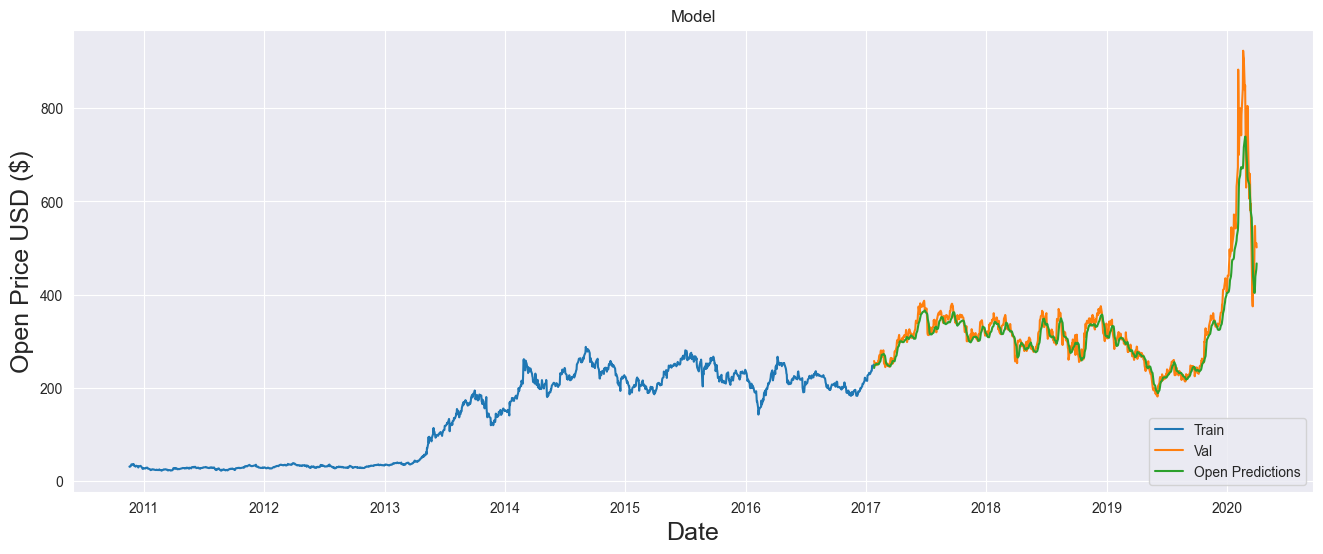

In [15]:
# Plot the data
train = data_open[:training_data_len]
open_valid = data_open[training_data_len:]
open_valid['Open Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(open_valid[['Open', 'Open Predictions']])
plt.legend(['Train', 'Val', 'Open Predictions'], loc='lower right')
plt.show()

In [16]:
open_valid

,Open,Open Predictions
Date,,
2017-01-25,257.309998,242.270615
2017-01-26,254.289993,245.381531
2017-01-27,251.380005,248.049377
2017-01-30,252.529999,249.765320
2017-01-31,249.240005,250.850098
...,...,...
2020-03-25,545.250000,403.534027
2020-03-26,547.390015,417.850891
2020-03-27,505.000000,438.465576


In [17]:
close_valid

,Close,Close Predictions
Date,,
2017-01-25,254.470001,237.093872
2017-01-26,252.509995,239.831314
2017-01-27,252.949997,241.749191
2017-01-30,250.630005,243.013824
2017-01-31,251.929993,243.432922
...,...,...
2020-03-25,539.250000,398.295593
2020-03-26,528.159973,417.779541
2020-03-27,514.359985,436.567047


In [18]:
# Now that we have both models, let's see if our models' predictions can accurately predict if the next day will go up or not (1 is up 0 is down)
merged = pd.concat([close_valid['Close Predictions'], open_valid['Open Predictions']], axis=1)

merged['Class'] = (merged['Close Predictions'] - merged['Open Predictions'] > 0).mul(1).shift(-1)

merged.head(-1)

,Close Predictions,Open Predictions,Class
Date,,,
2017-01-25,237.093872,242.270615,0.0
2017-01-26,239.831314,245.381531,0.0
2017-01-27,241.749191,248.049377,0.0
2017-01-30,243.013824,249.765320,0.0
2017-01-31,243.432922,250.850098,0.0
...,...,...,...
2020-03-24,388.188568,404.012512,0.0
2020-03-25,398.295593,403.534027,0.0
2020-03-26,417.779541,417.850891,0.0


Does not give desired results, since our model's open and close predictions never overlap. Instead, we can assume that the previous day close is the next day's open.

In [19]:
close_valid['Class Prediction'] = close_valid['Close Predictions'].gt(close_valid['Close Predictions'].shift())
close_valid.head(-1)

C:\Users\Brandon\AppData\Local\Temp\ipykernel_15600\2352476176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_valid['Class Prediction'] = close_valid['Close Predictions'].gt(close_valid['Close Predictions'].shift())


,Close,Close Predictions,Class Prediction
Date,,,
2017-01-25,254.470001,237.093872,False
2017-01-26,252.509995,239.831314,True
2017-01-27,252.949997,241.749191,True
2017-01-30,250.630005,243.013824,True
2017-01-31,251.929993,243.432922,True
...,...,...,...
2020-03-24,505.000000,388.188568,False
2020-03-25,539.250000,398.295593,True
2020-03-26,528.159973,417.779541,True


These results are more desirable, let's now compare it to the actual values

In [20]:
y_test = df.Class.iloc[training_data_len:]
y_pred = close_valid['Class Prediction']
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negative:', tn)
print('False Positive:', fp)
print('False Negative:', fn)
print('True Positive:', tp)

print('Accuracy Rate:', (tp + tn)/(fn+fp+tn+tp))

True negative: 172
False Positive: 217
False Negative: 182
True Positive: 230
Accuracy Rate: 0.50187265917603


Unfortunately, our model is only a little better than a simple coin toss.